# Chapter 18

In [35]:
install.packages("ggplot2")


Pobrane pakiety binarne sa w
	/var/folders/bx/vr1n7w6x7053h6fbl2jrprwm0000gn/T//RtmpoiK35R/downloaded_packages


In [1]:
library(MASS)

## be careful to load dplyr after MASS
library(dplyr)
library(tidyr)
library(purrr)
library(extraDistr)
library(ggplot2)
library(loo)
library(bridgesampling)
library(brms)
library(bayesplot)
library(tictoc)
library(hypr)
library(bcogsci)
library(lme4)
library(rstan)
# library(cmdstanr)
library(rootSolve)


Dolaczanie pakietu: 'dplyr'


Nastepujacy obiekt zostal zakryty z 'package:MASS':

    select


Nastepujace obiekty zostaly zakryte z 'package:stats':

    filter, lag


Nastepujace obiekty zostaly zakryte z 'package:base':

    intersect, setdiff, setequal, union



Dolaczanie pakietu: 'extraDistr'


Nastepujacy obiekt zostal zakryty z 'package:purrr':

    rdunif


This is loo version 2.5.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Ladowanie wymaganego pakietu: Rcpp

Loading 'brms' package (version 2.17.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Dolaczanie pakietu: 'brms'


Nastepujacy obiekt zostal zakryty z 'package:bridgesampling':

    bf


Nastepujace obiekty zostaly zakryte z 'package:

In [2]:
## Save compiled models:
rstan_options(auto_write = FALSE)
## Parallelize the chains using all the cores:
options(mc.cores = parallel::detectCores())
# To solve some conflicts between packages
select <- dplyr::select
extract <- rstan::extract

## A model for multiple responses using the multinomial likelihood

In [4]:
true_theta <- tibble(theta_NR = .2, 
                     theta_Neologism = .1,
                     theta_Formal = .2,
                     theta_Mixed = .08,
                     theta_Correct =  1 -
  (theta_NR + theta_Neologism + theta_Formal + theta_Mixed))

In [5]:
N_trials <- 100
(ans_mn <- rmultinom(1, N_trials, true_theta))

theta_NR,21
theta_Neologism,11
theta_Formal,24
theta_Mixed,7
theta_Correct,37


### Multinomial

Now, we’ll try to recover the probability of each answer with a model with the following likelihood:

$$
\begin{equation}
ans \sim \mathit{Multinomial}(\boldsymbol{\theta})
\end{equation}
$$
where
$$
\boldsymbol{\theta} = \{\theta_{nr}, \theta_{neol.}, \theta_{formal}, \theta_{mix}, \theta_{corr}\}
$$

A common prior for multinomial likelihood is the Dirichlet distribution, which extends the Beta distribution to cases where more than two categories are available.

$$
\begin{equation}
\boldsymbol{\theta} \sim \mathit{Dirichlet}(\boldsymbol{\alpha})
\end{equation}
$$

In [6]:
# Create a list:
# c(ans_mn) makes a vector out of the matrix ans_mn
data_mn <-  list(N_trials = N_trials,
                 ans = c(ans_mn))

In [17]:
fit_mn <- stan("stan_models_18/multinom.stan", data = data_mn)


In [18]:
print(fit_mn, pars = c("theta"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
theta[1] 0.21       0 0.04 0.14 0.18 0.21 0.23  0.29  4336    1
theta[2] 0.12       0 0.03 0.07 0.10 0.12 0.14  0.19  4348    1
theta[3] 0.24       0 0.04 0.16 0.21 0.23 0.26  0.33  4322    1
theta[4] 0.08       0 0.03 0.04 0.06 0.08 0.10  0.14  4003    1
theta[5] 0.36       0 0.05 0.27 0.32 0.35 0.39  0.45  4443    1

Samples were drawn using NUTS(diag_e) at Wed Sep 14 09:59:22 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



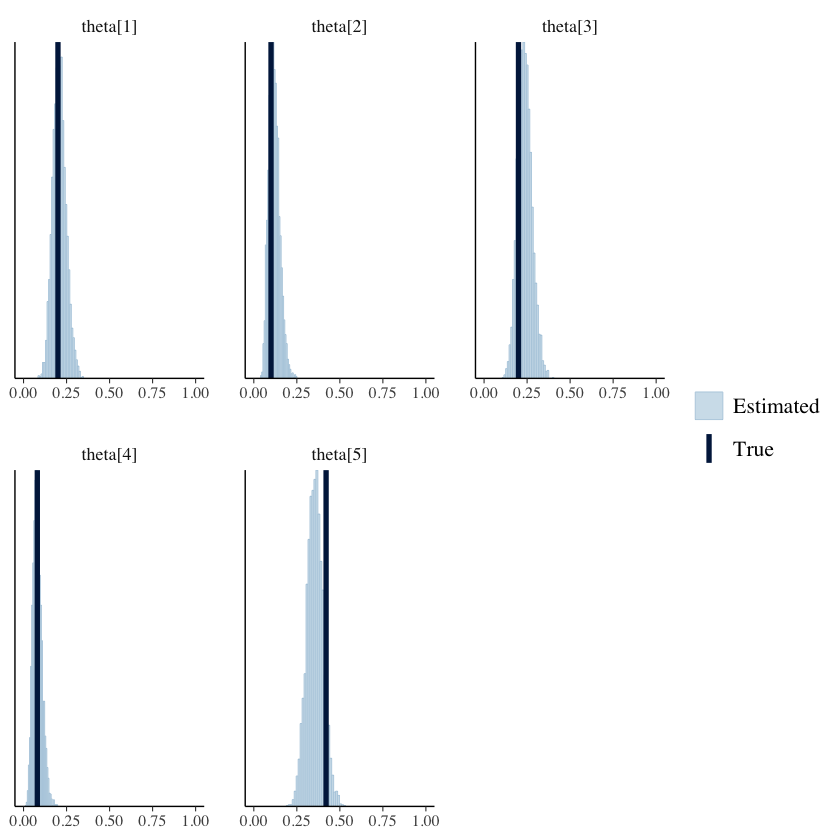

In [19]:
as.data.frame(fit_mn) %>%
  select(starts_with("theta")) %>%
  mcmc_recover_hist(true = unlist(true_theta)) +
  coord_cartesian(xlim = c(0, 1))

#### Categorical

In [11]:
N_obs <- 100 
ans_cat <- rcat(N_obs, prob = as.matrix(true_theta))

In [12]:
data_cat <-  list(N_obs = N_obs,
                  w_ans = ans_cat)

In [13]:
fit_cat <- stan("stan_models_18/categorical.stan", data = data_cat)  


In [20]:
print(fit_cat, pars = c("theta"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
theta[1] 0.20       0 0.04 0.13 0.17 0.20 0.23  0.28  4264    1
theta[2] 0.15       0 0.03 0.09 0.13 0.15 0.18  0.23  4872    1
theta[3] 0.21       0 0.04 0.14 0.18 0.21 0.23  0.29  4404    1
theta[4] 0.06       0 0.02 0.03 0.05 0.06 0.08  0.12  4601    1
theta[5] 0.37       0 0.05 0.29 0.34 0.37 0.40  0.47  4567    1

Samples were drawn using NUTS(diag_e) at Wed Sep 14 09:48:38 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Modeling picture naming abilities in aphasia with MPT models

Walker, Hickok, and Fridriksson (2018) created an MPT model that specifies a set of possible internal errors that lead to the various possible response types during a picture naming trial for aphasic patients. Here we’ll explore a simplification of the original model.

The model assumes that when an attempt is made to produce a word, errors in production can arise at the whole word level (lexical level) or the segmental level (phonological level). Semantic errors are assumed to arise from the lexical substitutions, and neologism errors from phonological substitutions. Real word responses that are phonologically related to the correct target word can arise from substitutions at the lexical or phonological level.

### The simplest model

First, simulate 200 trials assuming no variability between items and subjects. It is convenient to define functions to compute each outcome’s probability, based on the previous MPT. One needs to assign “true values” to the underlying parameters of the MPT, these values are for illustration. Ideally, one should simulate data using realistic values for the main parameters based on the literature.

In [41]:
# Probabilities of different answers
Pr_NR <- function(a, t, f, c)
    1 - a
Pr_Neologism <- function(a, t, f, c)
    a * (1 - t) * (1 - f) * (1 - c) + a * t * (1 - f) * (1 - c)
Pr_Formal <- function(a, t, f, c)
    a * (1 - t) * (1 - f) * c +  a * t * (1 - f) * c
Pr_Mixed <- function(a, t, f, c)
    a * (1 - t) * f
Pr_Correct <- function(a, t, f, c)
    a * t * f

# true underlying values for simulated data
a_true <- .75
t_true <- .9
f_true <- .8
c_true <- .1

# Probability of the different answers:
Theta <- tibble(NR = Pr_NR(a_true, t_true, f_true, c_true),
                Neologism = Pr_Neologism(a_true, t_true, f_true, c_true),
                Formal = Pr_Formal(a_true, t_true, f_true, c_true),
                Mixed = Pr_Mixed(a_true, t_true, f_true, c_true),
                Correct = Pr_Correct(a_true, t_true, f_true, c_true))

In [42]:
# generate data
N_trials <- 200
(ans <- rmultinom(1, N_trials, c(Theta)))

NR,49
Neologism,20
Formal,2
Mixed,13
Correct,116


In [21]:
# data for Stan
data_sMPT <-  list(N_trials = N_trials,
                   ans = c(ans)) 

In [23]:
fit_sMPT <- stan("stan_models_18/mpt_mnm.stan", data = data_sMPT)

In [24]:
print(fit_sMPT, pars = c("a", "t", "f", "c"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

  mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
a 0.71       0 0.03 0.65 0.69 0.71 0.73  0.77  3768    1
t 0.90       0 0.03 0.84 0.89 0.91 0.92  0.95  4875    1
f 0.76       0 0.04 0.69 0.74 0.76 0.79  0.83  4573    1
c 0.16       0 0.06 0.06 0.12 0.16 0.20  0.29  4997    1

Samples were drawn using NUTS(diag_e) at Wed Sep 14 10:08:32 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



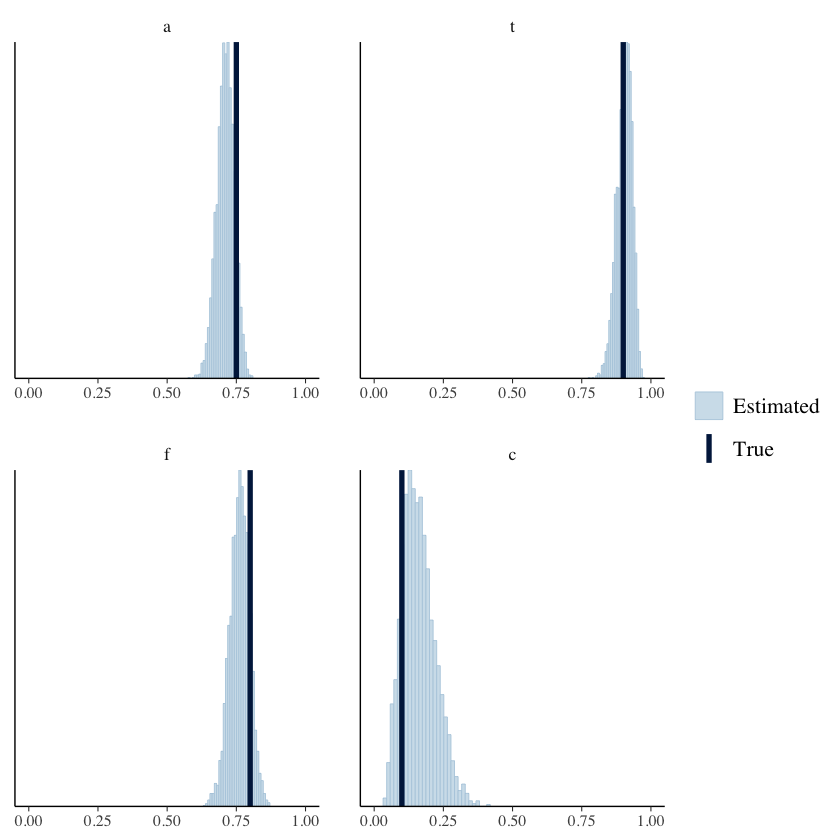

In [25]:
as.data.frame(fit_sMPT) %>%
  select(c("a","t","f","c")) %>%
  mcmc_recover_hist(true = c(a_true, t_true, f_true, c_true)) +
  coord_cartesian(xlim = c(0, 1))

In [26]:
print(fit_sMPT, pars = c("theta"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
theta[1] 0.29       0 0.03 0.23 0.27 0.29 0.31  0.35  3768    1
theta[2] 0.14       0 0.02 0.10 0.12 0.14 0.16  0.19  4571    1
theta[3] 0.03       0 0.01 0.01 0.02 0.03 0.03  0.05  4824    1
theta[4] 0.05       0 0.02 0.03 0.04 0.05 0.06  0.09  4950    1
theta[5] 0.49       0 0.03 0.42 0.47 0.49 0.51  0.56  4173    1

Samples were drawn using NUTS(diag_e) at Wed Sep 14 10:08:32 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


**This model is not falsifiable, so is almost usless for testing hypothesis/theories.**

## An MPT assuming by-item variability

In [43]:
N_obs <- 50
complexity <- rnorm(N_obs) # by default mean = 0, sd = 1
## choose some hypothetical values:
alpha_f <- .3
# the negative sign indicates that
# increased complexity will lead to a reduced value of f
beta_f <- -.3
# f' as a linear function of complexity
f_prime <- alpha_f + complexity * beta_f
head(f_prime)

[1] 0.44741104 0.43735265 0.30176196 0.50235454 0.91364130 0.04918532

In [44]:
f_true <- plogis(f_prime)
head(f_true)

[1] 0.6100235 0.6076280 0.5748732 0.6230125 0.7137447 0.5122939

In [45]:
theta_NR_v <- rep(Pr_NR(a_true, t_true, f_true, c_true), N_obs)
theta_Neologism_v <- Pr_Neologism(a_true, t_true, f_true, c_true)
theta_Formal_v <- Pr_Formal(a_true, t_true, f_true, c_true)
theta_Mixed_v <- Pr_Mixed(a_true, t_true, f_true, c_true)
theta_Correct_v <- Pr_Correct(a_true, t_true, f_true, c_true)
theta_item <- matrix(c(theta_NR_v,
                       theta_Neologism_v,
                       theta_Formal_v,
                       theta_Mixed_v,
                       theta_Correct_v),
                     ncol = 5)


[1] 50  5

In [46]:
head(theta_item,n = 3) 


0.25,0.2632341,0.02924824,0.04575176,0.4117659
0.25,0.2648511,0.02942790,0.04557210,0.4101489
0.25,0.2869606,0.03188451,0.04311549,0.3880394


In [47]:
sim_data_cx <- tibble(item = 1:N_obs,
                      complexity = complexity,
                      w_ans = c(rcat(N_obs,theta_item)))

In [48]:
data_cMPT <-  list(N_trials = N_trials,
                   w_ans = c(sim_data_cx$w_ans)) 

In [37]:
fit_cat_MPT <- stan("stan_models_18/mpt_cat.stan", data = data_cMPT)

In [38]:
fit_cat_MPT

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
a                0.67    0.00 0.06   0.53   0.62   0.67   0.71   0.78  3969
t                0.84    0.00 0.07   0.68   0.80   0.85   0.89   0.95  4246
f                0.61    0.00 0.08   0.45   0.55   0.61   0.66   0.76  4143
c                0.23    0.00 0.10   0.07   0.16   0.22   0.30   0.45  4074
theta[1,1]       0.33    0.00 0.06   0.22   0.29   0.33   0.38   0.47  3969
theta[1,2]       0.20    0.00 0.05   0.11   0.16   0.20   0.23   0.31  4276
theta[1,3]       0.06    0.00 0.03   0.02   0.04   0.06   0.08   0.13  3933
theta[1,4]       0.06    0.00 0.03   0.02   0.04   0.06   0.08   0.14  4010
theta[1,5]       0.34    0.00 0.06   0.23   0.30   0.34   0.38   0.46  4171
theta[2,1]       0.33    0.00 0.06   0.22   0.29   0.33   0.38   0.47  3969
theta[2,

We do not consider the impact of complexity, but it's a good start.

## A hierarchical MPT

The previous model doesn’t take into account that subjects might vary (and neither does the modification to this model that is suggested in exercise 18.3). Let’s focus on taking into account the differences between subjects.

Different subjects might not be equally motivated to do the task. This can be accounted by adding a hierarchical structure to the parameter $a$, the probability of initiating an attempt. Begin by simulating some data that incorporates by-subject variability.

First, define the number of items and subjects, and the number of observations:

In [39]:
N_item <- 20
N_subj <- 30
N_obs <- N_item * N_subj 

In [40]:
subj <- rep(1:N_subj, each = N_item)
item <- rep(1:N_item, time = N_subj)

In [41]:
complexity <- rep(rnorm(N_item), times = N_subj)

In [42]:
# create data
(exp_sim <- tibble(subj = subj,
                  item = item,
                  complexity = complexity)) 

subj,item,complexity
<int>,<int>,<dbl>
1,1,-1.73355518
1,2,1.16657661
1,3,-1.02179615
1,4,0.95745781
1,5,-0.75224042
1,6,0.15536685
1,7,1.85548471
1,8,0.75287635
1,9,-0.52472178


To create subject-level variability in the data, a between-subject standard deviation needs to be defined. This standard deviation represents the deviations of subjects about the grand mean. We are defining this adjustment in log-odds space.

In [48]:
# New parameters, in log-odds space:
tau_u_a <- 1.1

## generate *subject* adjustments in log-odds space:
u_a <- rnorm(N_subj, 0, tau_u_a)
head(u_a) 

[1]  0.48779110  0.02590477  1.44354414  0.49539093  0.58298305 -1.35184817

In [47]:
a_true <- .75 # as before

## convert the intercept to log-odds space:
alpha_a <- qlogis(a_true)

## a_h' in log-odds space:

a_h_prime <-  alpha_a + u_a[subj]

## convert back to probability space
a_true_h <- plogis(a_h_prime)
head(a_true_h) 

[1] 0.8548837 0.8548837 0.8548837 0.8548837 0.8548837 0.8548837

What this achieves mathematically is adding varying intercepts by subjects to alpha_a, and then the values adjusted by subject are saved in probability space.

If it is known that f is affected by the phonological complexity of the individual word.

As before, f_true is computed as a function of complexity:

In [50]:
alpha_f <- .3 
beta_f <- -.3
f_true <- plogis(alpha_f + complexity * beta_f)

In [52]:
t_true <- .9
c_true <- .1

In [53]:
Pr_NR <- function(a, t, f, c)
    1 - a
Pr_Neologism <- function(a, t, f, c)
    a * (1 - t) * (1 - f) * (1 - c) + a * t * (1 - f) * (1 - c)
Pr_Formal <- function(a, t, f, c)
    a * (1 - t) * (1 - f) * c +  a * t * (1 - f) * c
Pr_Mixed <- function(a, t, f, c)
    a * (1 - t) * f
Pr_Correct <- function(a, t, f, c)
    a * t * f

In [54]:
# Aux. parameters that define the probabilities:
theta_NR_v_h <- Pr_NR(a_true_h, t_true, f_true, c_true) 
theta_Neologism_v_h <- Pr_Neologism(a_true_h, t_true, f_true, c_true)
theta_Formal_v_h <- Pr_Formal(a_true_h, t_true, f_true, c_true)
theta_Mixed_v_h <- Pr_Mixed(a_true_h, t_true, f_true, c_true)
theta_Correct_v_h <- Pr_Correct(a_true_h, t_true, f_true, c_true)

theta_h <- matrix(
  c(theta_NR_v_h,
    theta_Neologism_v_h,
    theta_Formal_v_h,
    theta_Mixed_v_h,
    theta_Correct_v_h),
  ncol = 5)
  
dim(theta_h)

[1] 600   5

In [ ]:
(sim_data_h <- mutate(exp_sim,
                      w_ans = rcat(N_obs,theta_h)))

Now, we have varying parameter f (phonolog. as function) and a (angage as function). The parameters  
t,c do not vary by item or subject and therefore do not have the subscript

In [56]:
sim_list_h <-  list(N_obs = nrow(sim_data_h),
                    w_ans = sim_data_h$w_ans,
                    N_subj = max(sim_data_h$subj),
                    subj = sim_data_h$subj,
                    complexity = sim_data_h$complexity)

In [57]:
fit_mpt_h <- stan("stan_models_18/mpt_h.stan", data = sim_list_h)  


In [58]:
print(fit_mpt_h,
      pars = c("t", "c", "tau_u_a", "alpha_a", "alpha_f", "beta_f"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
t        0.88    0.00 0.02  0.84  0.87  0.88  0.90  0.92  8467    1
c        0.07    0.00 0.02  0.04  0.06  0.07  0.08  0.12  8946    1
tau_u_a  1.46    0.00 0.24  1.05  1.30  1.44  1.60  1.98  3112    1
alpha_a  0.79    0.01 0.30  0.22  0.57  0.78  0.98  1.42   916    1
alpha_f  0.46    0.00 0.11  0.25  0.39  0.46  0.54  0.67  8974    1
beta_f  -0.29    0.00 0.12 -0.52 -0.37 -0.29 -0.21 -0.06 10244    1

Samples were drawn using NUTS(diag_e) at Wed Sep 14 11:44:47 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


One could inspect how one unit of complexity is affecting the probability of retrieving the correct phoneme f


In [59]:
as.data.frame(fit_mpt_h) %>%
  select(alpha_f, beta_f) %>%
  mutate(f_0 = plogis(alpha_f),
         f_1 = plogis(alpha_f + beta_f),
         diff_f = f_1 - f_0) %>%
  summarize(Estimate = mean(diff_f),
          `2.5%` = quantile(diff_f, 0.025),
          `97.5%` = quantile(diff_f, 0.975)) 

Estimate,2.5%,97.5%
<dbl>,<dbl>,<dbl>
-0.07003292,-0.1279081,-0.01449169


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



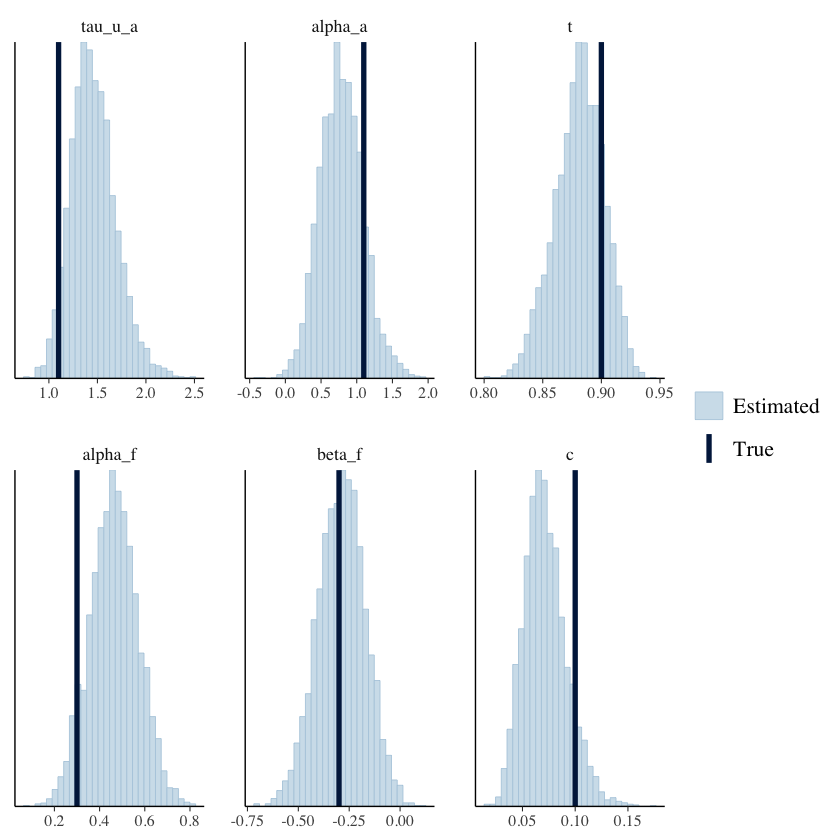

In [60]:
as.data.frame(fit_mpt_h) %>%
  select(tau_u_a, alpha_a, t, alpha_f, beta_f, c) %>%
  mcmc_recover_hist(true = c(tau_u_a,
                             qlogis(a_true),
                             t_true, alpha_f,
                             beta_f, c_true))  

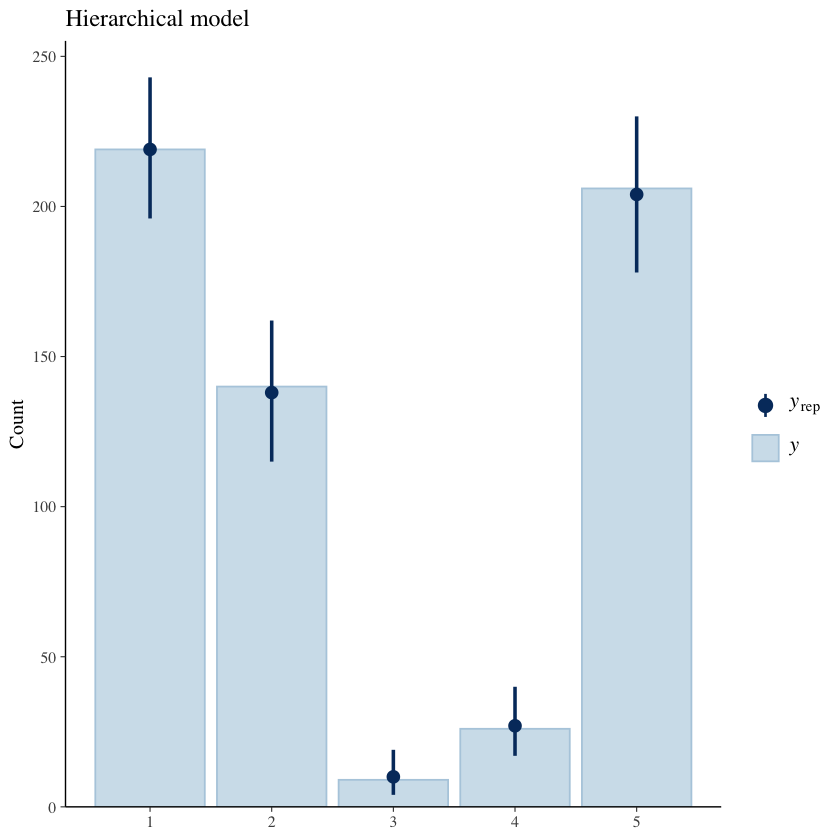

In [61]:
gen_data <- rstan::extract(fit_mpt_h)$pred_w_ans
ppc_bars(sim_list_h$w_ans, gen_data) +
  ggtitle ("Hierarchical model") 

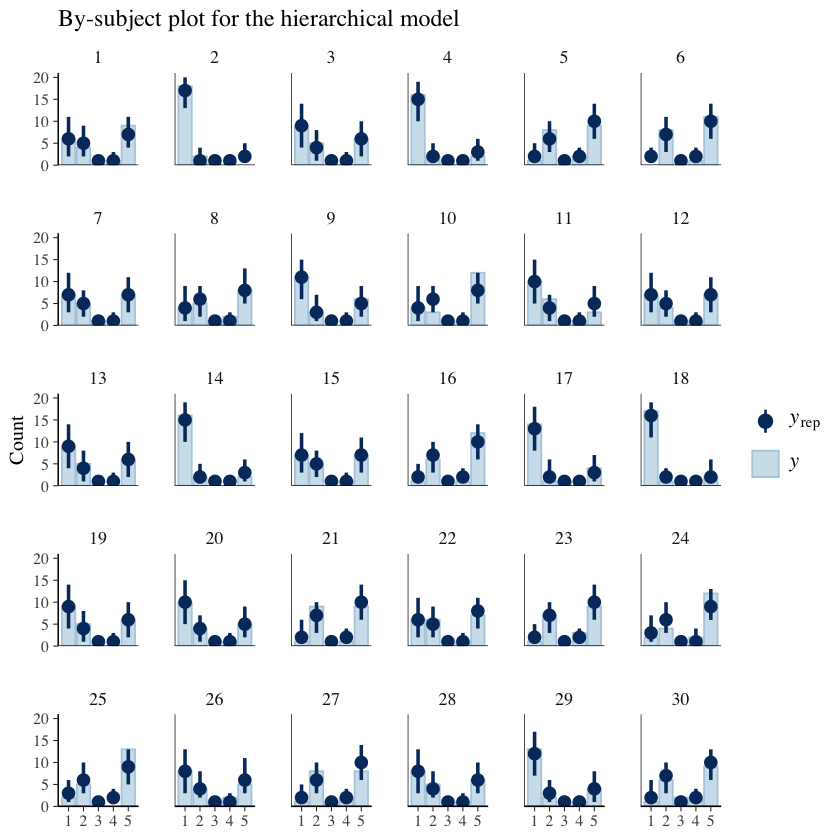

In [62]:
ppc_bars_grouped(sim_list_h$w_ans, 
                 gen_data, group = subj) +
  ggtitle ("By-subject plot for the hierarchical model")

Compare results to non-hierarchical model

In [67]:
fit_cat_MPT <- stan("stan_models_18/mpt_cat.stan", data = sim_list_h)

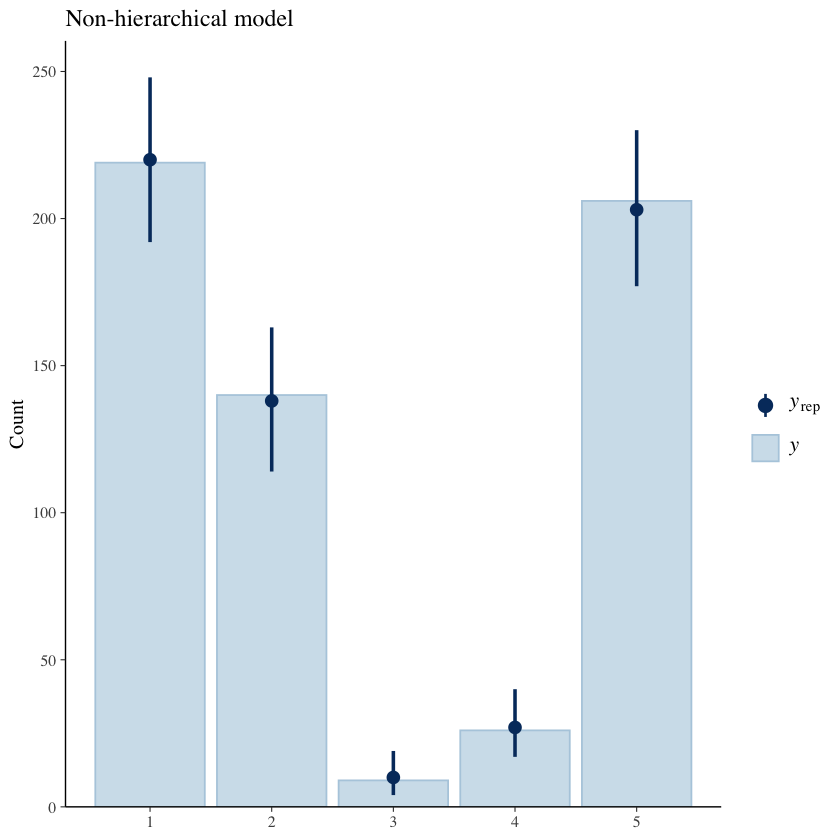

In [68]:
gen_data_sMPT <- rstan::extract(fit_cat_MPT)$pred_w_ans

ppc_bars(sim_list_h$w_ans, gen_data_sMPT) +
  ggtitle ("Non-hierarchical model")

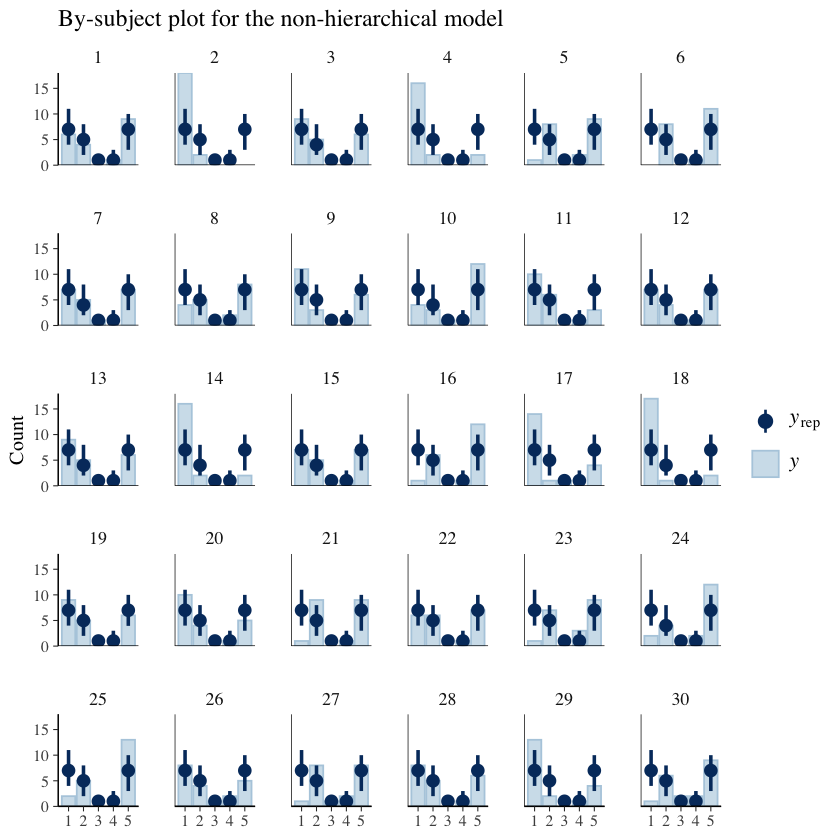

In [69]:
ppc_bars_grouped(sim_list_h$w_ans, gen_data_sMPT, group = subj) +
  ggtitle ("By-subject plot for the non-hierarchical model") 

# Excercises

## 18.1

In [70]:
N_obs <- 100 
ans_cat <- rcat(N_obs, prob = as.matrix(true_theta))

In [71]:
data_cat <-  list(N_obs = N_obs,
                  w_ans = ans_cat)

In [75]:
fit_cat <- stan("stan_models_18/categorical_18_1.stan", data = data_cat)  


In [77]:
print(fit_cat, pars = c("theta"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
theta[1] 0.13       0 0.02 0.09 0.11 0.13 0.15  0.18  4387    1
theta[2] 0.08       0 0.02 0.04 0.06 0.07 0.09  0.11  4290    1
theta[3] 0.17       0 0.03 0.13 0.16 0.17 0.19  0.23  4709    1
theta[4] 0.08       0 0.02 0.04 0.06 0.07 0.09  0.11  4790    1
theta[5] 0.55       0 0.03 0.48 0.52 0.55 0.57  0.61  4695    1

Samples were drawn using NUTS(diag_e) at Wed Sep 14 12:20:24 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



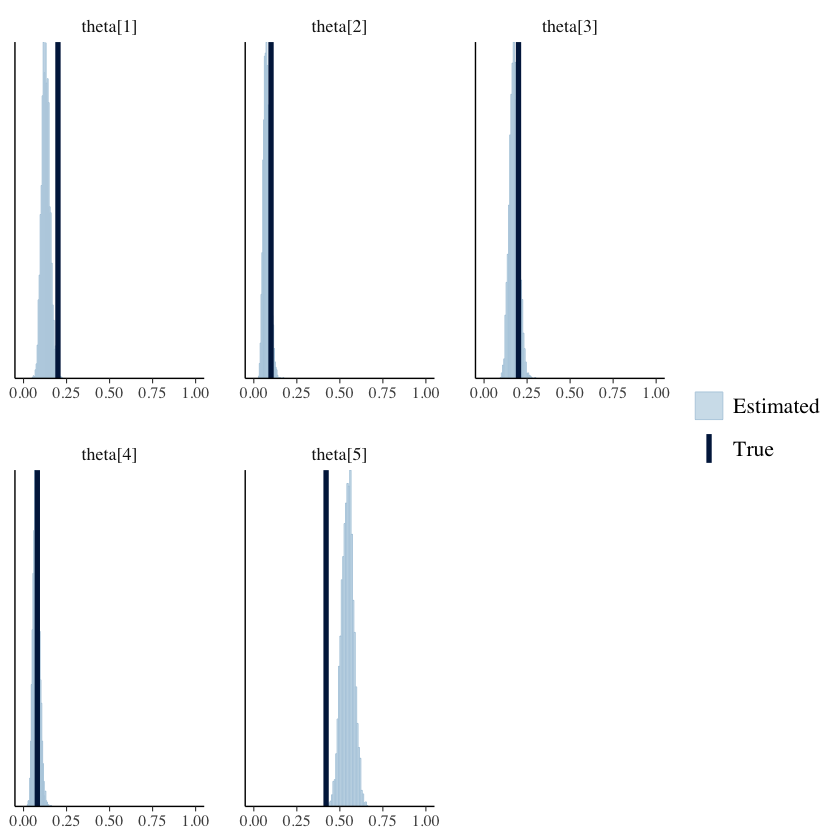

In [83]:
as.data.frame(fit_cat) %>%
  select(starts_with("theta")) %>%
  mcmc_recover_hist(true = unlist(true_theta)) +
  coord_cartesian(xlim = c(0, 1)) 

In [80]:
fit_cat_100 <- stan("stan_models_18/categorical_18_1.stan", data = data_cat)  


In [81]:
print(fit_cat_100, pars = c("theta"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
theta[1] 0.11       0 0.01 0.09 0.10 0.11 0.11  0.12  4673    1
theta[2] 0.10       0 0.01 0.08 0.09 0.10 0.10  0.11  3904    1
theta[3] 0.11       0 0.01 0.10 0.11 0.11 0.12  0.13  3944    1
theta[4] 0.10       0 0.01 0.08 0.09 0.10 0.10  0.11  4895    1
theta[5] 0.59       0 0.01 0.56 0.58 0.59 0.60  0.62  3729    1

Samples were drawn using NUTS(diag_e) at Wed Sep 14 12:23:28 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Now prior is so strong, that it cover the data.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



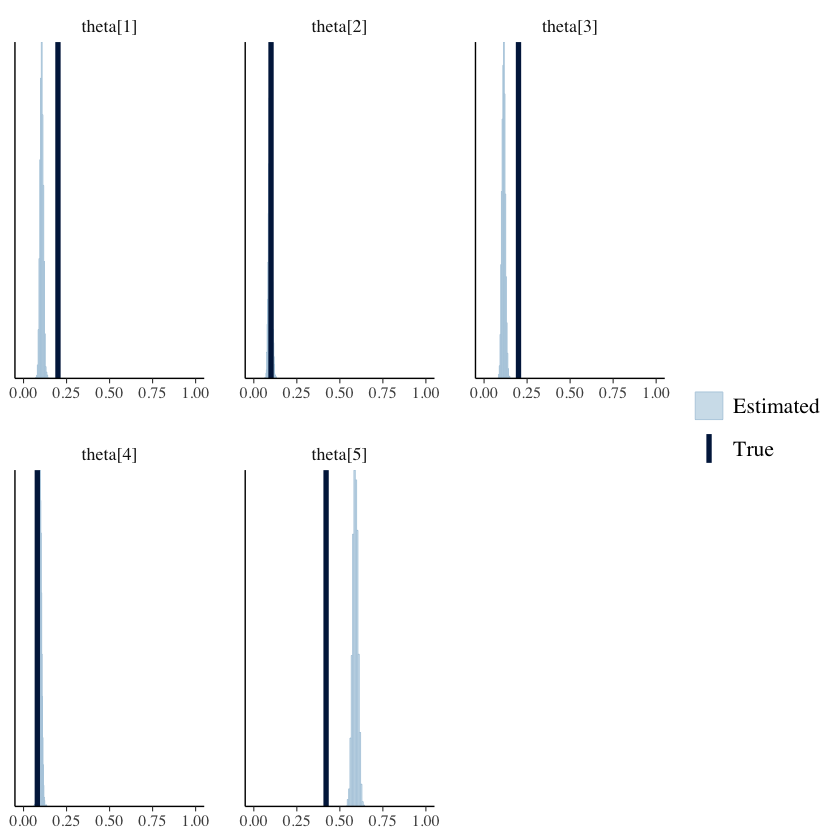

In [82]:
as.data.frame(fit_cat_100) %>%
  select(starts_with("theta")) %>%
  mcmc_recover_hist(true = unlist(true_theta)) +
  coord_cartesian(xlim = c(0, 1)) 

## 18.2

### An alternative MPT to model the picture recognition task.

In [91]:
# Probabilities of different answers
Pr_NR <- function(a, t, f, c)
    1 - a
Pr_Neologism <- function(a, t, f, c)
    a * (1 - t) * (1 - f) * (1 - c) + a * t * (1 - f) * (1 - c)
Pr_Formal <- function(a, t, f, c)
    a * (1 - t) * (1 - f) * c +  a * t * (1 - f) * c
Pr_Mixed <- function(a, t, f, c)
    a * (1 - t) * f
Pr_Correct <- function(a, t, f, c)
    a * t * f
# true underlying values for simulated data
a_true <- .75
t_true <- .9
f_true <- .8
c_true <- .1
# Probability of the different answers:
Theta <- tibble(NR = Pr_NR(a_true, t_true, f_true, c_true),
                Neologism = Pr_Neologism(a_true, t_true, f_true, c_true),
                Formal = Pr_Formal(a_true, t_true, f_true, c_true),
                Mixed = Pr_Mixed(a_true, t_true, f_true, c_true),
                Correct = Pr_Correct(a_true, t_true, f_true, c_true))
N_trials <- 200
(ans <- rmultinom(1, N_trials, c(Theta)))

NR,50
Neologism,26
Formal,2
Mixed,14
Correct,108


In [87]:
data_sMPT <-  list(N_trials = N_trials,
                   ans = c(ans))

In [95]:
fit_sMPT_2 <- stan("stan_models_18/tree_18_2.stan", data = data_sMPT) 

Warning message in .local(object, ...):
"some chains had errors; consider specifying chains = 1 to debug"
here are whatever error messages were returned



[[1]]
Stan model 'anon_model' does not contain samples.

[[2]]
Stan model 'anon_model' does not contain samples.

[[3]]
Stan model 'anon_model' does not contain samples.

[[4]]
Stan model 'anon_model' does not contain samples.



## 18.03

In [ ]:
N_obs <- 50
complexity <- rnorm(N_obs) # by default mean = 0, sd = 1
## choose some hypothetical values:

alpha_f <- .3
beta_f <- -.3

# f' as a linear function of complexity
f_prime <- alpha_f + complexity * beta_f
f_true <- plogis(f_prime)

[1] 0.44741104 0.43735265 0.30176196 0.50235454 0.91364130 0.04918532

In [ ]:
theta_NR_v <- rep(Pr_NR(a_true, t_true, f_true, c_true), N_obs)
theta_Neologism_v <- Pr_Neologism(a_true, t_true, f_true, c_true)
theta_Formal_v <- Pr_Formal(a_true, t_true, f_true, c_true)
theta_Mixed_v <- Pr_Mixed(a_true, t_true, f_true, c_true)
theta_Correct_v <- Pr_Correct(a_true, t_true, f_true, c_true)

theta_item <- matrix(c(theta_NR_v,
                       theta_Neologism_v,
                       theta_Formal_v,
                       theta_Mixed_v,
                       theta_Correct_v),
                     ncol = 5)


[1] 50  5

In [ ]:
sim_data_cx <- tibble(item = 1:N_obs,
                      complexity = complexity,
                      w_ans = c(rcat(N_obs,theta_item)))

In [ ]:
# data for Stan model
data_cMPT <-  list(N_trials = N_trials,
                   w_ans = c(sim_data_cx$w_ans)) 

In [51]:
fit_cat_MPT <- stan("stan_models_18/mpt_cat_beta.stan", data = data_cMPT)

In [54]:
print(fit_cat_MPT, pars = c("a", "t", "c", "alpha_f", "beta_f"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
a        0.70       0 0.06  0.58  0.66  0.71  0.75  0.82  4798    1
t        0.81       0 0.07  0.65  0.77  0.82  0.87  0.94  4753    1
c        0.24       0 0.10  0.08  0.16  0.23  0.30  0.45  4444    1
alpha_f  0.40       0 0.29 -0.16  0.20  0.39  0.60  1.00  4665    1
beta_f  -0.35       0 0.28 -0.93 -0.53 -0.35 -0.16  0.20  4728    1

Samples were drawn using NUTS(diag_e) at Wed Sep 14 16:17:27 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#### Compare to the model without complexity influence

In [126]:
fit_cat_MPT <- stan("stan_models_18/mpt_cat.stan", data = data_cMPT)

In [127]:
fit_cat_MPT

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
a                0.74    0.00 0.06   0.62   0.70   0.74   0.78   0.84  4063
t                0.87    0.00 0.07   0.71   0.83   0.88   0.92   0.97  4433
f                0.52    0.00 0.07   0.37   0.47   0.52   0.57   0.67  3873
c                0.18    0.00 0.08   0.05   0.12   0.17   0.23   0.36  4258
theta[1,1]       0.26    0.00 0.06   0.16   0.22   0.26   0.30   0.38  4063
theta[1,2]       0.29    0.00 0.06   0.18   0.25   0.29   0.33   0.41  4228
theta[1,3]       0.06    0.00 0.03   0.02   0.04   0.06   0.08   0.14  3987
theta[1,4]       0.05    0.00 0.03   0.01   0.03   0.04   0.06   0.12  4333
theta[1,5]       0.34    0.00 0.06   0.22   0.29   0.34   0.38   0.46  3808
theta[2,1]       0.26    0.00 0.06   0.16   0.22   0.26   0.30   0.38  4063
theta[2,

## 18.4

In [3]:
N_item <- 20
N_subj <- 30
N_obs <- N_item * N_subj 

In [4]:
subj <- rep(1:N_subj, each = N_item)
item <- rep(1:N_item, time = N_subj)

In [5]:
complexity <- rep(rnorm(N_item), times = N_subj)

In [6]:
exp_sim <- tibble(subj = subj,
                  item = item,
                  complexity = complexity)

In [7]:
# New parameters, in log-odds space:
tau_u_a <- 1.1
## generate subject adjustments in log-odds space:
u_a <- rnorm(N_subj, 0, tau_u_a)

In [8]:
# New parameters, in log-odds space:
tau_u_c <- 0.6
## generate subject adjustments in log-odds space:
u_c <- rnorm(N_subj, 0, tau_u_c)

In [9]:
# New parameters, in log-odds space:
tau_u_t <- 0.7
## generate subject adjustments in log-odds space:
u_t <- rnorm(N_subj, 0, tau_u_t)

In [10]:
# New parameters, in log-odds space:
tau_u_f <- 0.5
## generate subject adjustments in log-odds space:
u_f <- rnorm(N_subj, 0, tau_u_f)

In [11]:
a_true <- .75 # as before
t_true <- .9
c_true <- .1

## convert the intercept to log-odds space:
alpha_a <- qlogis(a_true)
alpha_t <- qlogis(t_true)
alpha_c <- qlogis(c_true)

## a_h' in log-odds space:
a_h_prime <-  alpha_a + u_a[subj]
t_h_prime <-  alpha_t + u_t[subj]
c_h_prime <-  alpha_c + u_c[subj]

## convert back to probability space
a_true_h <- plogis(a_h_prime)
t_true_h <- plogis(t_h_prime)
c_true_h <- plogis(c_h_prime)

In [12]:
alpha_f <- .3; 
beta_f <- -.3
f_true <- plogis(alpha_f + u_f + complexity * beta_f)

In [13]:
Pr_NR <- function(a, t, f, c)
    1 - a
Pr_Neologism <- function(a, t, f, c)
    a * (1 - t) * (1 - f) * (1 - c) + a * t * (1 - f) * (1 - c)
Pr_Formal <- function(a, t, f, c)
    a * (1 - t) * (1 - f) * c +  a * t * (1 - f) * c
Pr_Mixed <- function(a, t, f, c)
    a * (1 - t) * f
Pr_Correct <- function(a, t, f, c)
    a * t * f

In [14]:
theta_NR_v_h <- Pr_NR(a_true_h, t_true, f_true, c_true) 
theta_Neologism_v_h <- Pr_Neologism(a_true_h, t_true, f_true, c_true)
theta_Formal_v_h <- Pr_Formal(a_true_h, t_true, f_true, c_true)
theta_Mixed_v_h <- Pr_Mixed(a_true_h, t_true, f_true, c_true)
theta_Correct_v_h <- Pr_Correct(a_true_h, t_true, f_true, c_true)
theta_h <- matrix(
  c(theta_NR_v_h,
    theta_Neologism_v_h,
    theta_Formal_v_h,
    theta_Mixed_v_h,
    theta_Correct_v_h),
  ncol = 5)
dim(theta_h)

[1] 600   5

In [15]:
sim_data_h2 <- mutate(exp_sim,
                      w_ans = rcat(N_obs,theta_h))

In [16]:
sim_list_h2 <-  list(N_obs = nrow(sim_data_h2),
                    w_ans = sim_data_h2$w_ans,
                    N_subj = max(sim_data_h2$subj),
                    subj = sim_data_h2$subj,
                    complexity = sim_data_h2$complexity)

In [17]:
fit_mpt_h_full <- stan("stan_models_18/mpt_h_full2.stan", data = sim_list_h2) 

In [18]:
print(fit_mpt_h_full,
      pars = c("tau", "alpha","beta_f"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
tau[1]    0.81    0.00 0.17  0.52  0.69  0.80  0.91  1.16  1629    1
tau[2]    0.41    0.01 0.32  0.02  0.17  0.35  0.59  1.15  1591    1
tau[3]    0.35    0.01 0.27  0.02  0.14  0.31  0.51  0.99  1389    1
tau[4]    0.15    0.00 0.12  0.00  0.06  0.13  0.22  0.43  1898    1
alpha[1]  0.92    0.00 0.17  0.58  0.80  0.91  1.03  1.25  1379    1
alpha[2] -1.85    0.00 0.23 -2.30 -2.01 -1.85 -1.70 -1.41  3936    1
alpha[3]  1.82    0.00 0.19  1.46  1.69  1.81  1.95  2.19  3764    1
alpha[4]  0.46    0.00 0.11  0.25  0.39  0.46  0.53  0.68  3254    1
beta_f   -0.19    0.00 0.10 -0.38 -0.25 -0.19 -0.12  0.01  4554    1

Samples were drawn using NUTS(diag_e) at Thu Sep 15 09:16:59 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the

In [19]:
fit_mpt_h_full_df = as.data.frame(fit_mpt_h_full)
head(fit_mpt_h_full_df)

,alpha[1],alpha[2],alpha[3],alpha[4],beta_f,tau[1],tau[2],tau[3],tau[4],"z[1,1]",⋯,pred_w_ans[592],pred_w_ans[593],pred_w_ans[594],pred_w_ans[595],pred_w_ans[596],pred_w_ans[597],pred_w_ans[598],pred_w_ans[599],pred_w_ans[600],lp__
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.0115597,-1.919974,2.104928,0.4188319,-0.1091272,1.0109156,0.6426322,0.19084843,0.13771536,-0.4892594,⋯,4,3,4,5,5,5,1,2,5,-953.5086
2,0.8317903,-2.245853,1.717235,0.3905610,-0.2800379,0.7963031,1.1604230,0.02417307,0.11623795,-0.2972916,⋯,1,5,2,5,2,1,1,5,1,-944.9138
3,1.2143694,-2.166879,1.700628,0.6485828,-0.1990553,0.9728292,0.4011359,0.09042902,0.45789670,-1.1736371,⋯,1,5,1,5,1,2,5,2,2,-952.7342
4,1.1021745,-1.986985,1.956951,0.4037782,-0.2400613,0.7976132,0.8402156,0.20341338,0.11110352,-0.7600513,⋯,1,1,1,2,1,4,2,5,1,-954.2853
5,0.9632224,-1.980358,2.035645,0.3601281,-0.1944475,0.7984034,0.2472364,0.21801828,0.03601460,-1.0886163,⋯,1,1,2,5,1,1,2,2,1,-947.9829
6,0.9452528,-2.228648,2.002266,0.3316574,-0.1129863,0.5936055,0.3502111,0.36341140,0.03463263,-1.1675736,⋯,1,1,1,3,2,5,5,2,2,-952.4820


In [35]:
data_gen = select(fit_mpt_h_full_df, c("tau[1]", "tau[2]", "tau[3]", "tau[4]","alpha[1]", "alpha[2]", "alpha[3]", "alpha[4]", "beta_f"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



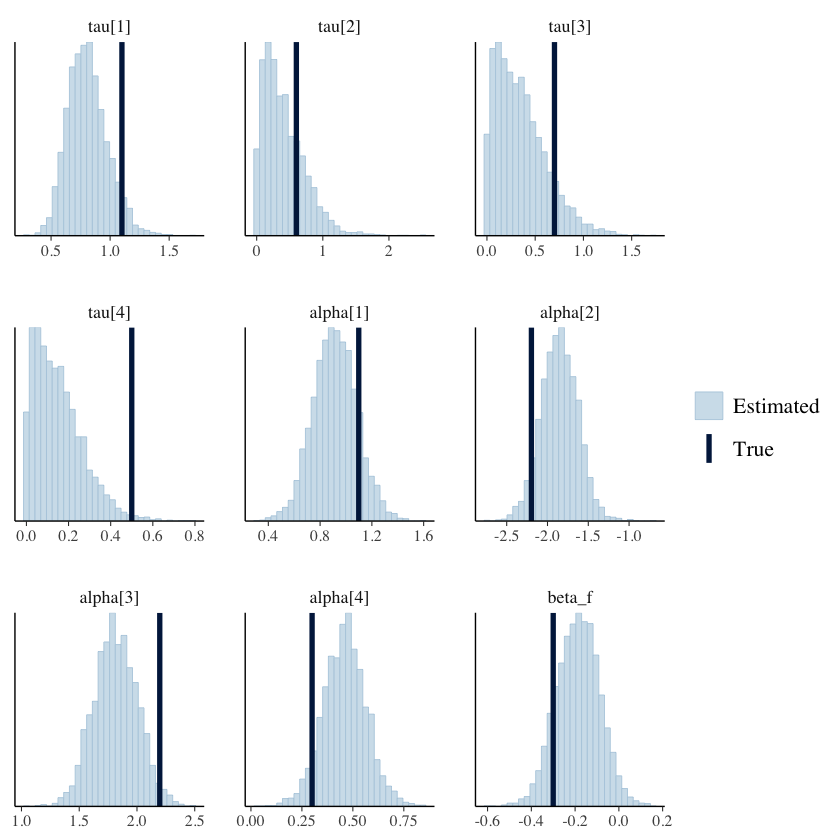

In [36]:
mcmc_recover_hist(x = select(data_gen, c("tau[1]", "tau[2]", "tau[3]", "tau[4]", "alpha[1]", "alpha[2]", "alpha[3]", "alpha[4]", "beta_f")), 
  true = c(
    tau_u_a, 
    tau_u_c,
    tau_u_t, 
    tau_u_f,  
    qlogis(a_true), 
    qlogis(c_true), 
    qlogis(t_true),
    alpha_f,
    beta_f
  )
)  

### Inspect by-subject plot of predictive checks

In [37]:
gen_data_sMPT <- rstan::extract(fit_mpt_h_full)$pred_w_ans

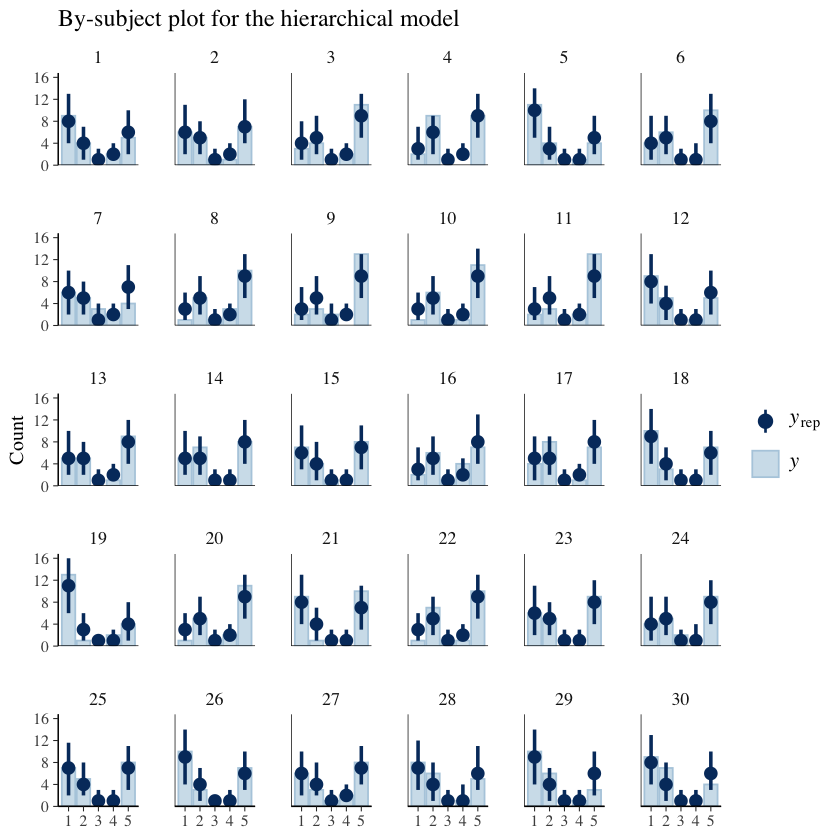

In [38]:
ppc_bars_grouped(sim_list_h2$w_ans, 
                 gen_data_sMPT, group = subj) +
  ggtitle ("By-subject plot for the hierarchical model")